## Test Shock Cooling: new model

Use the Piro et al. (2020) model to fit for multi-band early-time light curves.

In [1]:
import pandas as pd
import numpy as np
import scipy.optimize as op
from helper import phys
from allsn_info import get_at2019dge

In [2]:
import emcee
import time
import corner
from multiprocessing import Pool

In [3]:
from helper.arnett import model_arnett_modified

In [4]:
from helper.models_piro2020 import model_piro20, model_piro20_bol

In [5]:
import matplotlib
import matplotlib.pyplot as plt
fs = 14
matplotlib.rcParams['font.size']=fs

In [6]:
result = get_at2019dge(colorplt=False)
lc = result['tb']
lc = lc[lc.instrument!='P60+SEDM']
lcdet = lc.sort_values(by = ['mjd'])
t0mjd = result['t_max']
dates = np.unique(lcdet["date"].values)
lcdet["phase"] = lcdet["mjd"].values - t0mjd

In [7]:
ixearly = (lcdet["phase"].values < 20)#&(lcdet["instrument"].values != "Swift")
lcearly = lcdet[ixearly]

In [8]:
filts = np.unique(lcearly["filter"].values)

In [9]:
np.unique(lcearly["wave"].values)

array([2079. , 2255.1, 2614.2, 3475.5, 3479.2, 4359.1, 4795.5, 4814. ,
       5430.1, 6187.6, 6421.8, 7658.7, 7883.1, 9669.8])

In [10]:
tt = lcearly["phase"].values
wv = lcearly["wave"].values
filters = lcearly["filter"].values
wv[filters=="u"] = 3477
wv[filters=="U"] = 3477
wv[filters=="g"] = 4800
wv[filters=="r"] = 6300
wv[filters=="i"] = 7800
wv[filters=="z"] = 9670
filters = lcearly["filter"].values

In [14]:
lcearly["instrument"].values

array(['P48', 'P48', 'P48', 'P48', 'P48', 'LT+IOO', 'LT+IOO', 'LT+IOO',
       'LT+IOO', 'LT+IOO', 'P48', 'P48', 'Swift', 'Swift', 'Swift',
       'Swift', 'Swift', 'Swift', 'LT+IOO', 'LT+IOO', 'LT+IOO', 'P48',
       'Swift', 'Swift', 'Swift', 'Swift', 'Swift', 'Swift', 'LT+IOO',
       'LT+IOO', 'LT+IOO', 'LT+IOO', 'LT+IOO', 'P48', 'P48', 'P48', 'P48',
       'P48', 'P48', 'P48', 'P48', 'P48', 'P48', 'P48', 'LT+IOO',
       'LT+IOO', 'LT+IOO', 'LT+IOO', 'LT+IOO', 'LT+IOO', 'LT+IOO',
       'LT+IOO', 'P48', 'P48', 'LT+IOO', 'LT+IOO', 'LT+IOO', 'LT+IOO',
       'P48', 'P48', 'LT+IOO', 'LT+IOO', 'LT+IOO', 'P48', 'P48', 'LT+IOO',
       'LT+IOO', 'LT+IOO', 'LT+IOO', 'LT+IOO', 'LT+IOO', 'LT+IOO',
       'LT+IOO', 'LT+IOO', 'LT+IOO', 'LT+IOO', 'LT+IOO', 'P48', 'P48',
       'P48', 'LT+IOO', 'LT+IOO', 'LT+IOO', 'LT+IOO', 'P48', 'P48',
       'LT+IOO', 'LT+IOO', 'LT+IOO', 'LT+IOO', 'P48', 'LT+IOO', 'LT+IOO',
       'P48', 'P48', 'P48', 'LT+IOO'], dtype=object)

In [18]:
lcsw = lcearly[lcearly.instrument=="Swift"]

In [20]:
lcsw

,emag,filter,instrument,mag,mjd,wave,mag0,tmax_rf,tmax_of,mag0_abs,...,fnu_unc,nufnu,nufnu_unc,flambda,flambda_unc,Llambda,Llambda_unc,datetime64,date,phase
12,0.108,UVW1,Swift,18.685,58582.8261,2614.2,18.539416,-0.366102,-0.3739,-16.297250,...,1.192960e-14,137.533420,13.680680,0.052610,0.005233,6.294778e+38,6.261521e+37,2019-04-09T19:49:35.039999862,2019 04 09,-0.3739
13,0.113,U,Swift,18.289,58582.8280,3477.0,18.180024,-0.364242,-0.3720,-16.656642,...,1.737950e-14,144.041132,14.991347,0.041445,0.004313,4.958841e+38,5.161005e+37,2019-04-09T19:52:19.200000116,2019 04 09,-0.3720
14,0.193,B,Swift,18.606,58582.8289,4359.1,18.514642,-0.363360,-0.3711,-16.322024,...,2.181067e-14,84.383939,15.000053,0.019358,0.003441,2.316189e+38,4.117247e+37,2019-04-09T19:53:36.960000037,2019 04 09,-0.3711
15,0.103,UVW2,Swift,18.802,58582.8299,2079.0,18.591997,-0.362381,-0.3701,-16.244670,...,1.083944e-14,164.763220,15.630511,0.079251,0.007518,9.482366e+38,8.995590e+37,2019-04-09T19:55:03.359999741,2019 04 09,-0.3701
16,0.404,V,Swift,18.679,58582.8337,5430.1,18.609861,-0.358661,-0.3663,-16.226806,...,4.182209e-14,62.052818,23.089714,0.011428,0.004252,1.367303e+38,5.087702e+37,2019-04-09T20:00:31.680000247,2019 04 09,-0.3663
17,0.068,UVM2,Swift,18.550,58582.8346,2255.1,18.344709,-0.357779,-0.3654,-16.491958,...,8.986568e-15,190.749834,11.946722,0.084586,0.005298,1.012067e+39,6.338608e+37,2019-04-09T20:01:49.440000169,2019 04 09,-0.3654
22,0.101,UVW1,Swift,18.873,58583.5747,2614.2,18.727416,0.366885,0.3747,-16.109250,...,9.382604e-15,115.666672,10.759827,0.044246,0.004116,5.293957e+38,4.924673e+37,2019-04-10T13:47:34.079999775,2019 04 10,0.3747
23,0.107,U,Swift,18.512,58583.5766,3477.0,18.403024,0.368746,0.3766,-16.433642,...,1.340117e-14,117.296897,11.559685,0.033750,0.003326,4.038129e+38,3.979602e+37,2019-04-10T13:50:18.240000028,2019 04 10,0.3766
24,0.142,B,Swift,18.494,58583.5775,4359.1,18.402642,0.369627,0.3775,-16.434024,...,1.779098e-14,93.553447,12.235559,0.021462,0.002807,2.567875e+38,3.358443e+37,2019-04-10T13:51:35.999999950,2019 04 10,0.3775
25,0.098,UVW2,Swift,19.219,58583.5785,2079.0,19.008997,0.370606,0.3785,-15.827670,...,7.024183e-15,112.217418,10.128894,0.053977,0.004872,6.458278e+38,5.829328e+37,2019-04-10T13:53:02.400000282,2019 04 10,0.3785


In [18]:
Llambda = lcearly["Llambda"].values
Llambda_unc = lcearly["Llambda_unc"].values
lgL = np.log10(Llambda)
lgL_unc = Llambda_unc / Llambda / np.log(10)

scp models.py yyao@private.caltech.edu:/scratch/yyao/AT2019dge/playground/helper/

main_shockmodel()

This takes some time to run so put it on another machine

scp -r yyao@private.caltech.edu:/scratch/yyao/AT2019dge/playground/helper/piromodel .

Inspect results by different tcuts, I select tcut = 5.0 (the same as tcut = 5.5).

In [69]:
tcuts = np.array([1.0, 2.0, 3.0, 4.0])
for tcut in tcuts:
    filename = "./helper/piromodel_2020/"+"%.1f"%tcut+"/sampler.h5"
    reader = emcee.backends.HDFBackend(filename)
    lgprobs = reader.get_log_prob(discard=1000, flat=True)
    print (tcut, np.median(lgprobs))

1.0 28.55587344938644
2.0 20.986917861637316
3.0 2.827776424125858
4.0 -177.49252083856433


In [50]:
filename = "./helper/piromodel_2020/2.0/sampler.h5"
reader = emcee.backends.HDFBackend(filename)

In [51]:
samples = reader.get_chain(discard=1000, flat=True)
lgprobs = reader.get_log_prob(discard=1000, flat=True)
print (samples.shape)
print (lgprobs.shape)

(400000, 4)
(400000,)


In [52]:
lgR_sigmas = np.percentile(samples[:,0], (0.13, 2.27, 15.87, 50, 84.13, 97.73, 99.87))
lgM_sigmas = np.percentile(samples[:,1], (0.13, 2.27, 15.87, 50, 84.13, 97.73, 99.87))
t0_sigmas = np.percentile(samples[:,2], (0.13, 2.27, 15.87, 50, 84.13, 97.73, 99.87))
Eenvs_sigmas = np.percentile(samples[:,3], (0.13, 2.27, 15.87, 50, 84.13, 97.73, 99.87)) * 1e+49

In [53]:
Eenv = Eenvs_sigmas[3] 
Eenv_unc_left = Eenvs_sigmas[3]-Eenvs_sigmas[2]
Eenv_unc_right = Eenvs_sigmas[4] - Eenvs_sigmas[3]
print ("%.2f (+%.2f) (-%.2f) 1e+49 erg"%(Eenv/1e+49, Eenv_unc_right/1e+49, Eenv_unc_left/1e+49))

5.30 (+0.25) (-0.24) 1e+49 erg


In [54]:
Renv = 10**lgR_sigmas[3] 
Renv_unc_left = 10**lgR_sigmas[3] - 10**lgR_sigmas[2] 
Renv_unc_right = 10**lgR_sigmas[4] - 10**lgR_sigmas[3] 
print ("%.2f (+%.2f) (-%.2f) e+13 cm"%(Renv / 1e+13, Renv_unc_right/1e+13, Renv_unc_left/1e+13))

print ("%.1f (+%.1f) (-%.1f) Rsun"%(Renv / phys.sr, Renv_unc_right/phys.sr, Renv_unc_left/phys.sr))

1.19 (+0.06) (-0.05) e+13 cm
171.2 (+8.3) (-7.7) Rsun


In [55]:
Menv = 10**lgM_sigmas[3] 
Menv_unc_left = 10**lgM_sigmas[3] - 10**lgM_sigmas[2] 
Menv_unc_right = 10**lgM_sigmas[4] - 10**lgM_sigmas[3] 
print ("%.2f (+%.2f) (-%.2f) 1e-2 Msun"%(Menv*100, Menv_unc_right*100, Menv_unc_left*100))

9.71 (+0.28) (-0.27) 1e-2 Msun


In [56]:
deltat0 = t0_sigmas[3] 
deltat0_unc_left = t0_sigmas[3]-t0_sigmas[2]
deltat0_unc_right = t0_sigmas[4] - t0_sigmas[3]
print ("%.2f (+%.2f) (-%.2f) day"%(deltat0, deltat0_unc_right, deltat0_unc_left))
t0 =t0_sigmas[3]

-2.91 (+0.02) (-0.02) day


### Plot the model

/Users/yuhanyao/Documents/GitHub/AT2019dge/playground/helper/models_piro2020.py:68: RuntimeWarning: divide by zero encountered in true_divide
  L1 = prefactor * (td/t)**(4/(n-2))
/Users/yuhanyao/Documents/GitHub/AT2019dge/playground/helper/models_piro2020.py:76: RuntimeWarning: divide by zero encountered in true_divide
  R1 = (tph/t)**(2/(n-1)) * vt * t
/Users/yuhanyao/Documents/GitHub/AT2019dge/playground/helper/models_piro2020.py:76: RuntimeWarning: invalid value encountered in multiply
  R1 = (tph/t)**(2/(n-1)) * vt * t


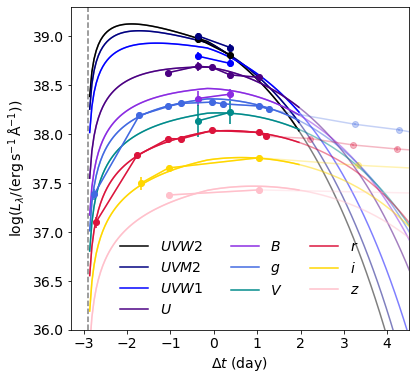

In [27]:
    plt.figure(figsize=(6, 5.5))
    ax = plt.subplot(111)
    wvs = np.array([2079. , 2255.1, 2614.2, 3477, 4359.1, 4800. , 5430.1, 6300. , 7800. , 9670. ])
    names = np.array(["$UVW2$", "$UVM2$", "$UVW1$", "$U$", "$B$", "$g$", "$V$", "$r$", "$i$", "$z$"])
    colors = np.array(["k", "navy", "b", "indigo", "blueviolet", "royalblue", "darkcyan", "crimson", "gold", "pink"])
    tgrid = np.linspace(0, 10, 200)
    for i in range(len(wvs)):
        wave = wvs[i]
        color = colors[i]
        name = names[i]
        ix = (wv == wave)&(tt<2)
        ix1 = wv == wave
        ax.errorbar(tt[ix], lgL[ix], lgL_unc[ix], fmt="o-", color = color)
        ax.errorbar(tt[ix1], lgL[ix1], lgL_unc[ix1], fmt="o-", color = color, alpha = 0.3)
        mymodel = model_piro20(tgrid, wv=wave, Renv=Renv, Menv_=Menv, Eext49 = Eenv/1e+49)
        lgLmodel = np.log10(mymodel)
        tnew = tgrid+t0
        ix = tnew < 2
        ax.plot(tnew[ix], lgLmodel[ix], color = color, label = name)
        ax.plot(tnew, lgLmodel, color = color, alpha = 0.5)
    ax.set_ylim(36, 39.3)
    ax.set_xlim(-3.3, 4.5)
    ax.plot([t0, t0], [36, 39.3], linestyle ="--", color = "grey")
    ax.legend(ncol = 3, frameon = False, loc = "best")
    ax.set_xlabel(r"$\Delta t$"+" (day)")
    ax.set_ylabel('log('+r'$L_{\lambda}/\rm(erg\,s^{-1}\,\AA^{-1}))$')
    plt.tight_layout()
    plt.savefig("../paper/figures/P20model.pdf")
    plt.show()

### Make corner plot

In [57]:
paramsNames_final = ['log' +r'$R_\mathrm{ext}$', 
              'log' +r'$M_\mathrm{ext}$', 
              r"$t_{\rm exp}$",
              r"$E_{\rm ext, 49}$"]
quantiles=[0.1587, 0.5, 0.8413]
samples_final = np.hstack([samples[:, :3], samples[:, -1].reshape(samples.shape[0], 1)])

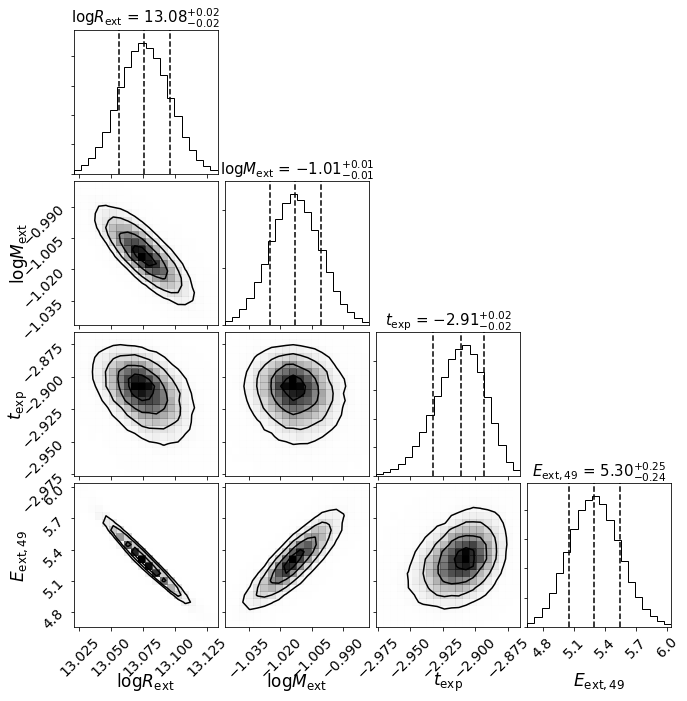

In [58]:
corner.corner(samples_final, labels = paramsNames_final, quantiles = quantiles, 
              range = [0.995, 0.995, 0.995, 0.995],
              show_titles=True, plot_datapoints=False, 
              label_kwargs = {"fontsize": fs+3},
              title_kwargs = {"fontsize": fs+1})
plt.savefig("../paper/figures/corner_P20.pdf")

In [59]:
filename1 = "./helper/arnettmodel/sampler.h5"
reader1 = emcee.backends.HDFBackend(filename1)
samples1 = reader1.get_chain(discard=200, flat=True)
taum_sigmas = np.percentile(samples1[:,0], (0.13, 2.27, 15.87, 50, 84.13, 97.73, 99.87))
lgMni_sigmas = np.percentile(samples1[:,1], (0.13, 2.27, 15.87, 50, 84.13, 97.73, 99.87))
t0_sigmas = np.percentile(samples1[:,2], (0.13, 2.27, 15.87, 50, 84.13, 97.73, 99.87))
taum_ = taum_sigmas[3]
lgMni_ = lgMni_sigmas[3]
Mni_ = 10**(lgMni_)
t0_ = t0_sigmas[3]

In [60]:
tgrid = np.linspace(0.1, 70, 200)
Lp20 = model_piro20_bol(tgrid, Menv, Renv, Eenv / 1e+49)
lgLp20 = np.log10(Lp20)

In [61]:
Lnidecay = model_arnett_modified(tgrid, taum_ = taum_, Mni_ = Mni_, t0_ = t0_)
lgLnidecay = np.log10(Lnidecay)
Ltot = Lp20 + Lnidecay
lgLtot = np.log10(Ltot)

In [62]:
result = get_at2019dge()
tb0 = result['tb']
z = result['z']

In [63]:
data = pd.read_csv('../data/otherSN/Yao2020/bbdata.csv')
data.head()

,phase,Lbb,Lbb_unc,Lbb_uncr,Lbb_uncl,lgLbb,lgLbb_unc,lgLbb_uncr,lgLbb_uncl,Tbb,Tbb_unc,Tbb_uncr,Tbb_uncl,Rbb,Rbb_unc,Rbb_uncr,Rbb_uncl
0,-2.736850,2.983949e+41,2.901282e+43,5.788449e+43,1.411515e+41,41.474791,1.284111,2.290004,0.278219,14209.202620,53235.759718,101350.845480,5120.673955,1450.464003,1139.962630,1137.222684,1142.702577
1,-1.724067,4.462538e+42,2.984460e+42,4.384533e+42,1.584387e+42,42.649582,0.243843,0.297218,0.190468,22748.482227,5871.154120,7601.148976,4141.159264,2197.606217,451.422801,442.160036,460.685565
2,-0.688169,2.695612e+42,8.937328e+40,9.163109e+40,8.711548e+40,42.430657,0.014392,0.014517,0.014267,15903.081905,278.858903,282.981835,274.735972,3495.688958,66.428478,66.900212,65.956744
3,0.237470,2.286527e+42,6.158605e+40,6.217315e+40,6.099896e+40,42.359176,0.011697,0.011651,0.011743,13509.819389,209.076025,209.236607,208.915443,4461.483449,82.266211,83.864443,80.667980
4,1.091643,1.750379e+42,3.852923e+40,3.958552e+40,3.747294e+40,42.243132,0.009555,0.009712,0.009399,12073.302239,186.266414,189.647163,182.885666,4887.427194,100.171427,100.525183,99.817671


In [64]:
t_data = data['phase'].values 
L_data = data['Lbb'].values
L_unc_data = data['Lbb_unc'].values
lgL_data = data['lgLbb'].values
lgL_unc_data = data['lgLbb_unc'].values
lgL_uncr_data = data['lgLbb_uncr'].values
lgL_uncl_data = data['lgLbb_uncl'].values

In [65]:
tb0 = tb0[tb0['filter'].values=='r']
tb0 = tb0[tb0.instrument!="P60+SEDM"]
tb0 = tb0[tb0.tmax_of > max(t_data)]
t_quasi = tb0["tmax_of"].values  
Lquasi = tb0["Llambda"].values * tb0['wave'].values
Lquasi_unc = tb0["Llambda_unc"].values * tb0['wave'].values
lgLquasi = np.log10(Lquasi)
lgLquasi_unc = Lquasi_unc / Lquasi / np.log(10)

In [66]:
def get_refineLbbaxis(ax):
    ax.set_ylabel(r'${\rm log} ( L/{\rm(erg\,s^{-1} } ))$')
    ax.set_xlabel('Time since explosion (days)')
    ax.xaxis.set_major_locator(plt.MultipleLocator(10))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(2))
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
    ax.tick_params(direction='in', axis='both', which = 'both', top=True, right=True)
    ax.tick_params(which = 'major', length = 4)
    ax.tick_params(which = 'minor', length = 2)

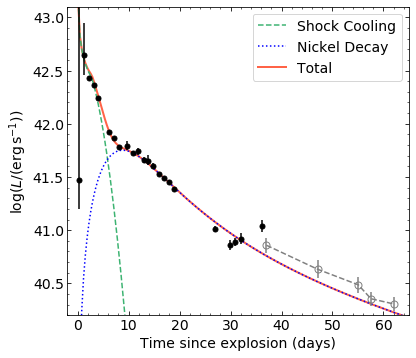

In [68]:
plt.figure(figsize=(6, 5.2))
ax = plt.subplot(111)
ax.errorbar(t_quasi-t0, lgLquasi, lgLquasi_unc, fmt='--o', color = "grey", markerfacecolor='none', zorder = 3, markersize=7)
ax.errorbar(t_data-t0, lgL_data, [lgL_uncl_data, lgL_uncr_data], fmt='ok', zorder = 3, markersize=5)

# Piro 2015 model
ax.plot(tgrid, lgLp20, color = "mediumseagreen", linestyle = "--", zorder = 2, label = "Shock Cooling")

# Modified Arnett model
ax.plot(tgrid, lgLnidecay, color = "b", linestyle = ":", zorder = 2, label = "Nickel Decay")

# Combined
ax.plot(tgrid, lgLtot, color = "tomato", linestyle = "-", zorder = 1, linewidth=2, label = "Total")

get_refineLbbaxis(ax)
ax.set_xlim(-2, 65)
ax.set_ylim(40.2, 43.1)
plt.tight_layout(h_pad=0)
plt.legend(loc = "upper right", fontsize= fs)
plt.savefig("../paper/figures/Lbb.pdf")

In [46]:
t0

-2.9112151494264173